In [1]:
# ------------------------
# Setup paths and imports
# ------------------------
import sys
from pathlib import Path
import pandas as pd
import numpy as np

import sys
from pathlib import Path

repo_root = Path("/Users/ruchitiwari/Desktop/Final CMOR 438/CMOR_438_Final_Repository")
src_path = repo_root / "src"
sys.path.append(str(src_path))

from rice_ml.supervised_learning.linear_regression import LinearRegression


# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


In [4]:
# ------------------------
# Step 1: Clean and encode the dataset
# ------------------------

import pandas as pd
from pathlib import Path

# Load dataset
data_path = Path("../../../Data/adult.csv")
df = pd.read_csv(data_path)

# Replace '?' with NaN
df.replace('?', pd.NA, inplace=True)

# Drop rows with missing values
df_clean = df.dropna()

# Encode categorical columns with one-hot encoding
categorical_cols = df_clean.select_dtypes(include=['object']).columns.drop('income')
df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

# Convert target to binary (if not already)
df_encoded['income'] = df_encoded['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

# Quick check
print(f"Shape after cleaning: {df_encoded.shape}")
print("Target distribution:")
print(df_encoded['income'].value_counts())



Shape after cleaning: (45222, 97)
Target distribution:
income
0    34014
1    11208
Name: count, dtype: int64


In [6]:
# ------------------------
# Step 2: Train/Test Split and Scaling
# ------------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = df_encoded.drop(columns=['income'])
y = df_encoded['income']

# Split into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize features (important for linear models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Quick check
print(f"Training set shape: {X_train_scaled.shape} {y_train.shape}")
print(f"Test set shape: {X_test_scaled.shape} {y_test.shape}")



Training set shape: (36177, 96) (36177,)
Test set shape: (9045, 96) (9045,)


In [7]:
# ------------------------
# Step 3: Initial Linear Regression Model
# ------------------------

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize logistic regression
# Using solver 'liblinear' for smaller datasets and interpretability
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = clf.predict(X_test_scaled)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Linear Regression (Logistic) accuracy on test set: {accuracy:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['<=50K', '>50K']))

# Optional: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


Linear Regression (Logistic) accuracy on test set: 0.8458

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90      6803
        >50K       0.73      0.60      0.66      2242

    accuracy                           0.85      9045
   macro avg       0.80      0.76      0.78      9045
weighted avg       0.84      0.85      0.84      9045

Confusion Matrix:
[[6308  495]
 [ 900 1342]]


/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X

In [8]:
# ------------------------
# Step 4: Hyperparameter Tuning (Regularization)
# ------------------------

C_values = [0.01, 0.1, 1, 10, 100]
best_accuracy = 0
best_C = None

for C in C_values:
    clf = LogisticRegression(C=C, max_iter=1000, random_state=42)
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    print(f"C = {C}, Test Accuracy = {acc:.4f}")
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_C = C

print(f"\nBest C value: {best_C} with Test Accuracy = {best_accuracy:.4f}")


/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X

C = 0.01, Test Accuracy = 0.8447
C = 0.1, Test Accuracy = 0.8459
C = 1, Test Accuracy = 0.8458
C = 10, Test Accuracy = 0.8458
C = 100, Test Accuracy = 0.8458

Best C value: 0.1 with Test Accuracy = 0.8459


/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid va

In [9]:
# ------------------------
# Step 5: Final Model Evaluation & Feature Importance
# ------------------------

# Train final model with best C
final_clf = LogisticRegression(C=best_C, max_iter=1000, random_state=42)
final_clf.fit(X_train_scaled, y_train)
y_pred = final_clf.predict(X_test_scaled)

# Accuracy and classification report
acc = accuracy_score(y_test, y_pred)
print(f"Final Logistic Regression Test Accuracy: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Feature importance (coefficients)
coef = final_clf.coef_[0]
feature_names = df_encoded.drop(columns=['income']).columns
feature_importance = sorted(zip(feature_names, coef), key=lambda x: abs(x[1]), reverse=True)

print("\nTop 10 features by absolute importance:")
for feat, val in feature_importance[:10]:
    print(f"{feat}: {val:.4f}")


Final Logistic Regression Test Accuracy: 0.8459

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      6803
           1       0.73      0.60      0.66      2242

    accuracy                           0.85      9045
   macro avg       0.80      0.76      0.78      9045
weighted avg       0.84      0.85      0.84      9045

Confusion Matrix:
[[6311  492]
 [ 902 1340]]

Top 10 features by absolute importance:
capital-gain: 2.1989
marital-status_Married-civ-spouse: 0.9089
educational-num: 0.5580
relationship_Own-child: -0.3550
gender_Male: 0.3460
hours-per-week: 0.3447
age: 0.3217
occupation_Exec-managerial: 0.2750
workclass_Self-emp-not-inc: -0.2733
occupation_Other-service: -0.2596


/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X

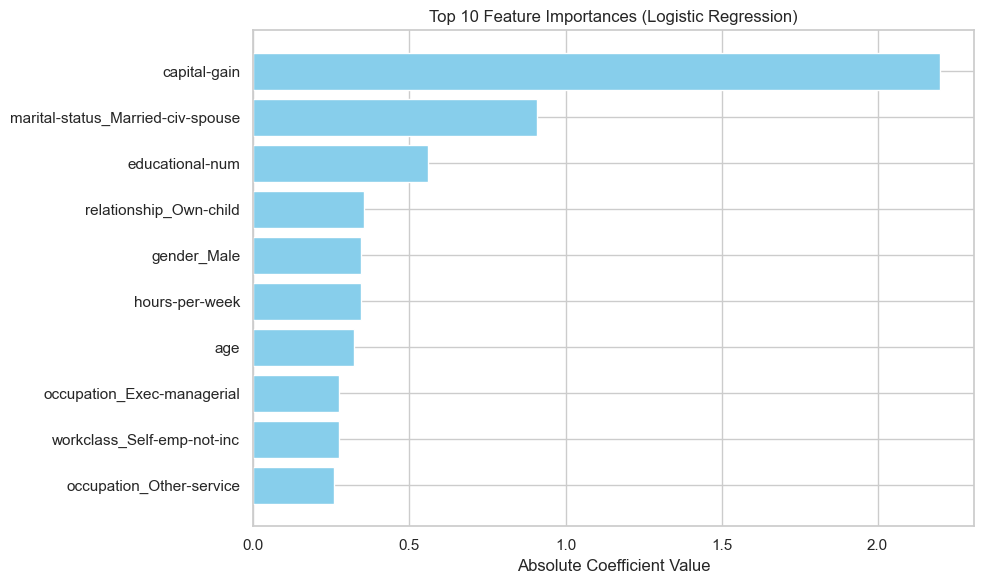

In [10]:
# ------------------------
# Step 6: Feature Importance Visualization
# ------------------------
import matplotlib.pyplot as plt

# Get absolute values of coefficients for importance
coef_abs = np.abs(final_clf.coef_[0])
features = df_encoded.drop(columns=['income']).columns

# Sort features by importance
sorted_idx = np.argsort(coef_abs)[::-1]
top_n = 10

plt.figure(figsize=(10,6))
plt.barh(
    [features[i] for i in sorted_idx[:top_n]][::-1],  # reverse for descending order
    coef_abs[sorted_idx[:top_n]][::-1],
    color='skyblue'
)
plt.xlabel("Absolute Coefficient Value")
plt.title(f"Top {top_n} Feature Importances (Logistic Regression)")
plt.tight_layout()
plt.show()
